In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import scipy.integrate as spi
import h5py
import os
import seaborn as sns

from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

In [2]:
file_path = '/fred/oz009/cpower/TheThreeHundred/NewMDCLUSTER_001/GIZMO_7k-NewMDCLUSTER_001.snap_128.z0.000.AHF_halos'
with open(file_path, 'r') as file:
    print(file.readline())  

#ID(1)	hostHalo(2)	numSubStruct(3)	Mhalo(4)	npart(5)	Xc(6)	Yc(7)	Zc(8)	VXc(9)	VYc(10)	VZc(11)	Rhalo(12)	Rmax(13)	r2(14)	mbp_offset(15)	com_offset(16)	Vmax(17)	v_esc(18)	sigV(19)	lambda(20)	lambdaE(21)	Lx(22)	Ly(23)	Lz(24)	b(25)	c(26)	Eax(27)	Eay(28)	Eaz(29)	Ebx(30)	Eby(31)	Ebz(32)	Ecx(33)	Ecy(34)	Ecz(35)	ovdens(36)	nbins(37)	fMhires(38)	Ekin(39)	Epot(40)	SurfP(41)	Phi0(42)	cNFW(43)	n_gas(44)	M_gas(45)	lambda_gas(46)	lambdaE_gas(47)	Lx_gas(48)	Ly_gas(49)	Lz_gas(50)	b_gas(51)	c_gas(52)	Eax_gas(53)	Eay_gas(54)	Eaz_gas(55)	Ebx_gas(56)	Eby_gas(57)	Ebz_gas(58)	Ecx_gas(59)	Ecy_gas(60)	Ecz_gas(61)	Ekin_gas(62)	Epot_gas(63)	n_star(64)	M_star(65)	lambda_star(66)	lambdaE_star(67)	Lx_star(68)	Ly_star(69)	Lz_star(70)	b_star(71)	c_star(72)	Eax_star(73)	Eay_star(74)	Eaz_star(75)	Ebx_star(76)	Eby_star(77)	Ebz_star(78)	Ecx_star(79)	Ecy_star(80)	Ecz_star(81)	Ekin_star(82)	Epot_star(83)	mean_z_gas(84)	mean_z_star(85)	n_star_excised(86)	M_star_excised(87)	mean_z_star_excised(88)	



In [3]:
DM_density = np.loadtxt('./data/density_profiles_GIZMO_7k_DM.txt')
Gas_density = np.loadtxt('./data/density_profiles_GIZMO_7k_gas.txt')
Stars_density = np.loadtxt('./data/density_profiles_GIZMO_7k_stars.txt')
Gas_sph_density = np.loadtxt('./data/density_sph_profiles_GIZMO_7k_gas.txt')
Gas_entropy = np.loadtxt('./data/entropy_profiles_GIZMO_7k_gas.txt')
Gas_internalenergy = np.loadtxt('./data/internal_energy_profiles_GIZMO_7k_gas.txt')
M200_R200 = np.loadtxt('./data/cluster_M200_R200_GIZMO_7k_snap128.txt')
Properties = np.loadtxt('./data/cluster_properties_GIZMO_7k_snap128.txt')
History = np.loadtxt('./data/M200_histories_GIZMO.txt')

print(DM_density.shape,Gas_density.shape,Stars_density.shape,Gas_sph_density.shape,Gas_entropy.shape,Gas_internalenergy.shape
     ,M200_R200.shape, Properties.shape)

(324, 100) (324, 100) (324, 100) (324, 100) (324, 100) (324, 100) (324, 2) (324, 86)


1.7475284000076847


(-6.8, 3.0)

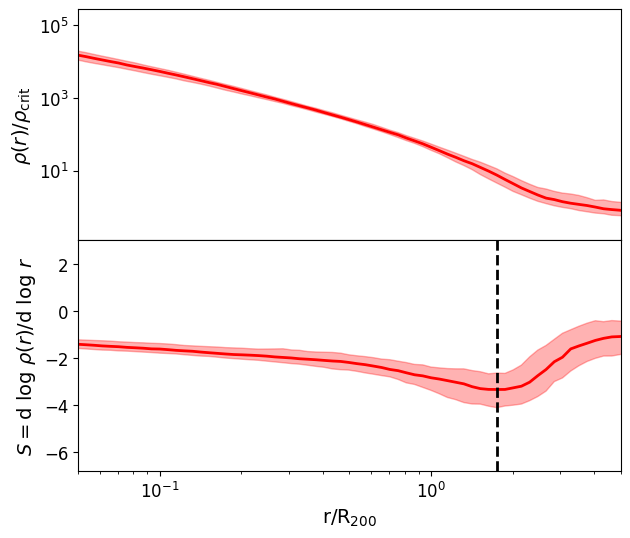

In [4]:
# DM density profile
Rsp=[]
rhonorm=2.7753662724817174e-08#*0.6777**2
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple', 'brown']
start = 0.01
end = 10
log_bins = np.logspace(np.log10(start), np.log10(end), 100)


fig = plt.figure(figsize=(7, 6))
fig.subplots_adjust(hspace=0.0)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

for i in range(DM_density.shape[0]):
# for i in range(10):
    # ax1.plot(log_bins, DM_density[i]/rhonorm, color='blue',linewidth=0.5, alpha=0.3)
    smoothed_density = gaussian_filter1d(DM_density[i], sigma=2)
    # smoothed_density = savgol_filter(DM_density[i], window_length=15, polyorder=3, deriv=0, delta=0.1)
    log_D = np.log(smoothed_density)
    log_r = np.log(log_bins)
    d_log_D = np.gradient(log_D, log_r)   
    # ax2.plot(log_bins, d_log_D, color='blue', linestyle='-', linewidth=2.0)
    # smoothed_d_log_D = savgol_filter(d_log_D, window_length=15, polyorder=4, deriv=0, delta=0.01)
    smoothed_d_log_D = gaussian_filter1d(d_log_D, sigma=2)
    # ax2.plot(log_bins, smoothed_d_log_D, color='blue', linestyle='-', linewidth=0.5, alpha=0.3) # colors[i % len(colors)]
    
    restricted_indices = np.where((log_bins >= 0.5) & (log_bins <= 4))[0]
    rr = log_bins[restricted_indices]
    smoothed_d_log_D_restricted = smoothed_d_log_D[restricted_indices]
    
    r_splash_index = np.argmin(smoothed_d_log_D_restricted)
    r_splash = rr[r_splash_index]

    interp_func = interp1d(log_bins, smoothed_d_log_D, kind='cubic')
    log_bins_dense = np.linspace(r_splash-0.1, r_splash+0.1, 1000)
    smoothed_d_log_D_dense = interp_func(log_bins_dense)
    max_index = np.argmin(smoothed_d_log_D_dense)
    r_splash = log_bins_dense[max_index]

    Rsp.append(r_splash)
    # ax2.axvline(x=r_splash, color='black', linestyle='--', linewidth=0.2)

# mean_DM_density = np.mean(DM_density, axis=0)
# ax1.plot(log_bins, mean_DM_density/rhonorm, color='red', linewidth=3.0, alpha=1)

median_DM_density = np.median(DM_density, axis=0)
percentile16_DM_density = np.percentile(DM_density, 16, axis=0)
percentile84_DM_density = np.percentile(DM_density, 84, axis=0)

ax1.plot(log_bins, median_DM_density / rhonorm, color='red', linewidth=2.0, alpha=1)
ax1.fill_between(log_bins, percentile16_DM_density / rhonorm, percentile84_DM_density / rhonorm, color='red', alpha=0.3)

d_log_D_all = []
for density in DM_density:
    # smoothed_density = savgol_filter(density, window_length=15, polyorder=4, deriv=0, delta=0.1)
    smoothed_density = gaussian_filter1d(density, sigma=2)
    log_D = np.log(smoothed_density)
    d_log_D = np.gradient(log_D, log_r)
    # smoothed_d_log_D = savgol_filter(d_log_D, window_length=15, polyorder=4, deriv=0, delta=0.01)
    smoothed_d_log_D = gaussian_filter1d(d_log_D, sigma=2)
    d_log_D_all.append(smoothed_d_log_D)

d_log_D_all = np.array(d_log_D_all)
median_d_log_D = np.median(d_log_D_all, axis=0)
percentile16_d_log_D = np.percentile(d_log_D_all, 16, axis=0)
percentile84_d_log_D = np.percentile(d_log_D_all, 84, axis=0)

ax2.plot(log_bins, median_d_log_D, color='red', linestyle='-', linewidth=2.0)
ax2.fill_between(log_bins, percentile16_d_log_D, percentile84_d_log_D, color='red', alpha=0.3)

# smoothed_density = savgol_filter(mean_DM_density, window_length=15, polyorder=4, deriv=0, delta=0.1)
# log_D = np.log(smoothed_density)
# log_r = np.log(log_bins)
# d_log_D = np.gradient(log_D, log_r)   
# smoothed_d_log_D = savgol_filter(d_log_D, window_length=15, polyorder=4, deriv=0, delta=0.01)
# ax2.plot(log_bins, smoothed_d_log_D, color='r', linestyle='-', linewidth=3.0) # colors[i % len(colors)]

restricted_indices = np.where((log_bins >= 0.5) & (log_bins <= 4))[0]
rr = log_bins[restricted_indices]
smoothed_d_log_D_restricted = median_d_log_D[restricted_indices]
r_splash_index = np.argmin(smoothed_d_log_D_restricted)
r_splash1 = rr[r_splash_index]
ax2.axvline(x=r_splash1, color='black', linestyle='--', linewidth=2.0)
print(r_splash1)

ax1.set_ylabel(r'$\rho(r)/\rho_{\rm crit}$', fontsize=14) #{\rm Log}_{10} 
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(0.05,5)
ax1.get_xaxis().set_visible(False)
ax1.tick_params(axis='both', which='major', labelsize=12)

ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xscale('log')
# ax2.set_yscale('log')
ax2.set_xlabel(r'${\rm r/R}_{200}$', fontsize=14)
ax2.set_ylabel(r'$S = {\rm d~log}~\rho(r) / {\rm d~log}~r$', fontsize=14)
# ax2.set_ylabel(r'$S$')
ax2.set_xlim(0.05,5)
ax2.set_ylim(-6.8,3)
# plt.savefig("./figures/DM_splashback_radius.png")

In [5]:
M200 = M200_R200[:,0]
R200 = M200_R200[:,1]
K200 = 0.5 / (200*rhonorm*0.156)**(2/3) * 4.3e-6 * M200 / R200
print(K200[:10])

[2.90725583e+10 2.54095735e+10 2.42338734e+10 2.41377136e+10
 2.44231990e+10 2.43705992e+10 2.17157724e+10 2.54399047e+10
 2.15931493e+10 2.04324524e+10]


2.31012970008316
4.037017258596554


(-6.0, 3.5)

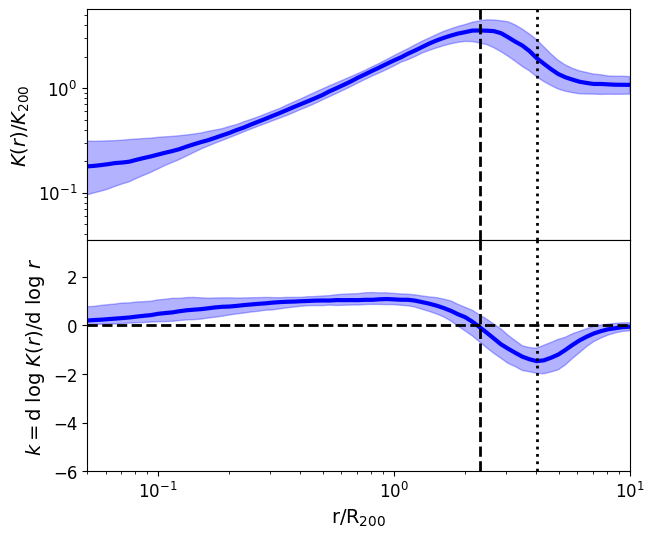

In [6]:
# Gas entropy profile
Rsh=[]
Gas_K=[]
fig = plt.figure(figsize=(7, 6))
fig.subplots_adjust(hspace=0.0)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

for i in range(Gas_entropy.shape[0]):
# for i in range(10):
    # ax1.plot(log_bins, Gas_entropy[i]/K200[i], color='blue',linewidth=0.5, alpha=0.3)
    # smoothed_entropy = savgol_filter(Gas_entropy[i]/K200[i], window_length=15, polyorder=4, deriv=0, delta=0.1)
    smoothed_entropy = gaussian_filter1d(Gas_entropy[i]/K200[i], sigma=2)
    log_D = np.log(smoothed_entropy)
    log_r = np.log(log_bins)
    d_log_D = np.gradient(log_D, log_r)   
    # ax2.plot(log_bins, d_log_D, color='blue', linestyle='-', linewidth=2.0)
    # smoothed_d_log_D = savgol_filter(d_log_D, window_length=15, polyorder=4, deriv=0, delta=0.01)
    smoothed_d_log_D = gaussian_filter1d(d_log_D, sigma=2)
    # ax2.plot(log_bins, smoothed_d_log_D, color='blue', linestyle='-', linewidth=0.5, alpha=0.3) # colors[i % len(colors)]

    r_range_mask = (log_bins >= 1) & (log_bins <= 5)
    rgav_1_in_range = log_bins[r_range_mask]
    umed_av_in_range = smoothed_entropy[r_range_mask]
    
    if len(umed_av_in_range) > 0:
        max_entropy_index = np.argmax(umed_av_in_range)
        r_shock = rgav_1_in_range[max_entropy_index]
        # ax1.axvline(x=r_shock, color='black', linestyle='--', linewidth=1)
        
        interp_func = interp1d(log_bins, smoothed_entropy, kind='cubic')
        log_bins_dense = np.linspace(r_shock-0.1, r_shock+0.1, 1000)
        smoothed_entropy_dense = interp_func(log_bins_dense)
        max_index = np.argmax(smoothed_entropy_dense)
        r_shock = log_bins_dense[max_index]
    
        # ax1.axvline(x=r_shock, color='black', linestyle='--', linewidth=0.2)
        # ax2.axvline(x=r_shock, color='black', linestyle='--', linewidth=0.2)
    Rsh.append(r_shock)
    Gas_K.append(smoothed_entropy)

# mean_Gas_entropy = np.mean(Gas_K, axis=0)
# ax1.plot(log_bins, mean_Gas_entropy, color='r',linewidth=3.0, alpha=1)
# smoothed_entropy = savgol_filter(mean_Gas_entropy, window_length=15, polyorder=4, deriv=0, delta=0.1)
# log_D = np.log(smoothed_entropy)
# log_r = np.log(log_bins)
# d_log_D = np.gradient(log_D, log_r)   
# smoothed_d_log_D = savgol_filter(d_log_D, window_length=15, polyorder=4, deriv=0, delta=0.01)
# ax2.plot(log_bins, smoothed_d_log_D, color='r', linestyle='-', linewidth=3.0) # colors[i % len(colors)]

median_Gas_entropy = np.median(Gas_K, axis=0)
percentile16_Gas_entropy = np.percentile(Gas_K, 16, axis=0)
percentile84_Gas_entropy = np.percentile(Gas_K, 84, axis=0)
ax1.plot(log_bins, median_Gas_entropy, color='blue', linewidth=3.0, alpha=1)
ax1.fill_between(log_bins, percentile16_Gas_entropy, percentile84_Gas_entropy, color='blue', alpha=0.3)

d_log_D_all = []
for entropy in Gas_K:
    # smoothed_entropy = savgol_filter(entropy, window_length=15, polyorder=4, deriv=0, delta=0.1)
    smoothed_entropy = gaussian_filter1d(entropy, sigma=2)
    log_D = np.log(smoothed_entropy)
    d_log_D = np.gradient(log_D, log_r)
    # smoothed_d_log_D = savgol_filter(d_log_D, window_length=15, polyorder=4, deriv=0, delta=0.01)
    smoothed_d_log_D = gaussian_filter1d(d_log_D, sigma=2)
    d_log_D_all.append(smoothed_d_log_D)

d_log_D_all = np.array(d_log_D_all)
median_d_log_D = np.median(d_log_D_all, axis=0)
percentile16_d_log_D = np.percentile(d_log_D_all, 16, axis=0)
percentile84_d_log_D = np.percentile(d_log_D_all, 84, axis=0)
ax2.plot(log_bins, median_d_log_D, color='blue', linestyle='-', linewidth=3.0)
ax2.fill_between(log_bins, percentile16_d_log_D, percentile84_d_log_D, color='blue', alpha=0.3)

r_range_mask = (log_bins >= 1) & (log_bins <= 5)
rgav_1_in_range = log_bins[r_range_mask]
umed_av_in_range = median_Gas_entropy[r_range_mask]
if len(umed_av_in_range) > 0:
    max_entropy_index = np.argmax(umed_av_in_range)
    r_shock1 = rgav_1_in_range[max_entropy_index]
ax1.axvline(x=r_shock1, color='black', linestyle='--', linewidth=2)
ax2.axvline(x=r_shock1, color='black', linestyle='--', linewidth=2)
print(r_shock1)

restricted_indices = np.where((log_bins >= 0.5) & (log_bins <= 6))[0]
rr = log_bins[restricted_indices]
smoothed_d_log_D_restricted = median_d_log_D[restricted_indices]
r_splash_index = np.argmin(smoothed_d_log_D_restricted)
r_splash2 = rr[r_splash_index]
ax1.axvline(x=r_splash2, color='black', linestyle=':', linewidth=2.0)
ax2.axvline(x=r_splash2, color='black', linestyle=':', linewidth=2.0)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=2.0)
print(r_splash2)

ax1.set_ylabel(r'$K(r)/K_{200}$', fontsize=14) #/K_{200}
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(0.05,10)
ax1.get_xaxis().set_visible(False)
ax1.tick_params(axis='both', which='major', labelsize=12)

ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlabel(r'${\rm r/R}_{200}$', fontsize=14)
ax2.set_ylabel(r'$k = {\rm d~log}~K(r) / {\rm d~log}~r$', fontsize=14)
ax2.set_xscale('log')
# ax2.set_yscale('log')
ax2.set_xlim(0.05,10)
ax2.set_ylim(-6,3.5)
# plt.savefig("./figures/GAS_shock_radius.png")

324 324


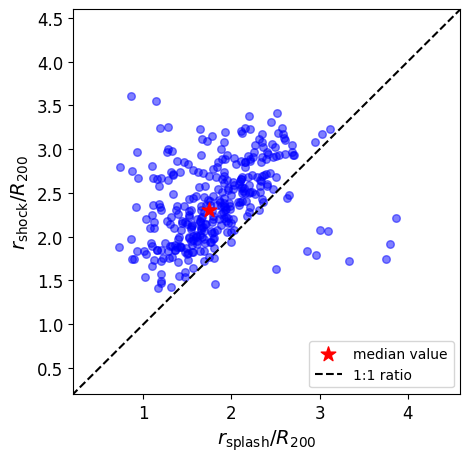

In [7]:
import seaborn as sns
print(len(Rsp), len(Rsh))
fig = plt.figure(figsize=(5, 5))
plt.scatter(Rsp, Rsh, color='blue',s=30, alpha=0.5)
plt.scatter(r_splash1, r_shock1, color='r',s=120, marker='*', label='median value')
# print(np.mean(Rsp), np.mean(Rsh), np.mean(Rsh)/np.mean(Rsp))
plt.plot([0.1, 6], [0.1, 6], color='black', linestyle='--', label='1:1 ratio')

# x = np.array(Rsp)
# y = np.array(Rsh)
# num_bins = 4
# bin_edges = np.linspace(np.min(x), np.max(x), num_bins+1)
# bin_indices = np.digitize(x, bin_edges) 
# bin_medians = np.array([np.median(y[bin_indices == i]) for i in range(1, num_bins + 1)])
# bin_q1 = np.array([np.percentile(y[bin_indices == i], 16) for i in range(1, num_bins + 1)])
# bin_q3 = np.array([np.percentile(y[bin_indices == i], 84) for i in range(1, num_bins + 1)])
 
# plt.errorbar((bin_edges[1:] + bin_edges[:-1]) / 2, bin_medians, yerr=[bin_medians - bin_q1, bin_q3 - bin_medians], fmt='o', color='r', capsize=4)
# plt.plot((bin_edges[1:] + bin_edges[:-1]) / 2, bin_medians,color='r')

# sns.kdeplot(Rsp, Rsh, cmap="viridis", shade=False, thresh=0.05, levels=15)
# cbar = plt.colorbar()
# cbar.set_label('Density')


plt.xlabel(r'$r_{\rm splash}/R_{200}$', fontsize=14)
plt.ylabel(r'$r_{\rm shock}/R_{200}$', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(0.2,4.6)
plt.ylim(0.2,4.6)
plt.legend(loc='lower right')
# plt.savefig("./figures/Rsplash_Rshock_324.png")

/tmp/ipykernel_3645557/1369705612.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=Rsp, y=Rsh, cmap="viridis", shade=False, thresh=0.05, levels=5)


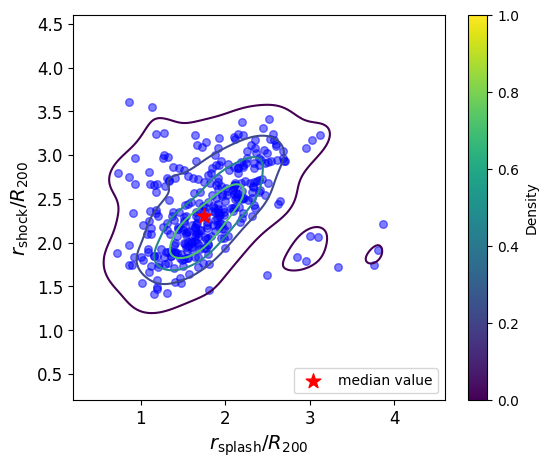

In [8]:
import seaborn as sns
fig = plt.figure(figsize=(6, 5))
plt.scatter(Rsp, Rsh, color='blue',s=30, alpha=0.5)
plt.scatter(r_splash1, r_shock1, color='r',s=120, marker='*', label='median value')
sns.kdeplot(x=Rsp, y=Rsh, cmap="viridis", shade=False, thresh=0.05, levels=5)

cbar = plt.colorbar()
cbar.set_label('Density')

plt.xlabel(r'$r_{\rm splash}/R_{200}$', fontsize=14)
plt.ylabel(r'$r_{\rm shock}/R_{200}$', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(0.2,4.6)
plt.ylim(0.2,4.6)
plt.legend(loc='lower right')
plt.show()

In [9]:

R=[]
RR=[]
for i in range(DM_density.shape[0]):
# for i in range(10):
    # ax1.plot(log_bins, DM_density[i]/rhonorm, color='blue',linewidth=0.5, alpha=0.3)
    # smoothed_density = savgol_filter(DM_density[i], window_length=15, polyorder=4, deriv=0, delta=0.1)
    smoothed_density = gaussian_filter1d(DM_density[i], sigma=2)
    log_D = np.log(smoothed_density)
    log_r = np.log(log_bins)
    d_log_D = np.gradient(log_D, log_r)   
    # ax2.plot(log_bins, d_log_D, color='blue', linestyle='-', linewidth=2.0)
    # smoothed_d_log_D = savgol_filter(d_log_D, window_length=15, polyorder=4, deriv=0, delta=0.01)
    smoothed_d_log_D = gaussian_filter1d(d_log_D, sigma=2)
    # ax2.plot(log_bins, smoothed_d_log_D, color='blue', linestyle='-', linewidth=0.5, alpha=0.3) # colors[i % len(colors)]
    
    restricted_indices = np.where((log_bins >= 0.5) & (log_bins <= 4))[0]
    rr = log_bins[restricted_indices]
    smoothed_d_log_D_restricted = smoothed_d_log_D[restricted_indices]
    
    r_splash_index = np.argmin(smoothed_d_log_D_restricted)
    r_splash = rr[r_splash_index]

    interp_func = interp1d(log_bins, smoothed_d_log_D, kind='cubic')
    log_bins_dense = np.linspace(r_splash-0.1, r_splash+0.1, 1000)
    smoothed_d_log_D_dense = interp_func(log_bins_dense)
    max_index = np.argmax(smoothed_d_log_D_dense)
    r_splash = log_bins_dense[max_index]

    # Rsp.append(r_splash)
    # ax2.axvline(x=r_splash, color='black', linestyle='--', linewidth=0.2)
    
    # ax1.plot(log_bins, Gas_entropy[i]/K200[i], color='blue',linewidth=0.5, alpha=0.3)
    # smoothed_entropy = savgol_filter(Gas_entropy[i]/K200[i], window_length=15, polyorder=4, deriv=0, delta=0.1)
    smoothed_entropy = gaussian_filter1d(Gas_entropy[i]/K200[i], sigma=2)
    log_D = np.log(smoothed_entropy)
    log_r = np.log(log_bins)
    d_log_D = np.gradient(log_D, log_r)   
    # ax2.plot(log_bins, d_log_D, color='blue', linestyle='-', linewidth=2.0)
    # smoothed_d_log_D = savgol_filter(d_log_D, window_length=15, polyorder=4, deriv=0, delta=0.01)
    smoothed_d_log_D = gaussian_filter1d(d_log_D, sigma=2)
    # ax2.plot(log_bins, smoothed_d_log_D, color='blue', linestyle='-', linewidth=0.5, alpha=0.3) # colors[i % len(colors)]

    r_range_mask = (log_bins >= 1) & (log_bins <= 5)
    rgav_1_in_range = log_bins[r_range_mask]
    umed_av_in_range = smoothed_entropy[r_range_mask]
    
    if len(umed_av_in_range) > 0:
        max_entropy_index = np.argmax(umed_av_in_range)
        r_shock = rgav_1_in_range[max_entropy_index]
        # ax1.axvline(x=r_shock, color='black', linestyle='--', linewidth=1)
        
        interp_func = interp1d(log_bins, smoothed_entropy, kind='cubic')
        log_bins_dense = np.linspace(r_shock-0.1, r_shock+0.1, 1000)
        smoothed_entropy_dense = interp_func(log_bins_dense)
        max_index = np.argmax(smoothed_entropy_dense)
        r_shock = log_bins_dense[max_index]
    
        # ax1.axvline(x=r_shock, color='black', linestyle='--', linewidth=0.2)
        # ax2.axvline(x=r_shock, color='black', linestyle='--', linewidth=0.2)
    # Rsh.append(r_shock)
    if r_shock<r_splash:
        R.append(i)
        RR.append([r_splash,r_shock])


print(R, len(R))
print(RR, len(RR))

[5, 10, 67, 78, 96, 100, 124, 126, 143, 146, 156, 159, 170, 180, 187, 213, 236, 246, 298, 323] 20
[[2.756087782946687, 2.440740019655375], [2.9538555088334153, 2.0627865561186014], [3.6649358067924673, 2.2093896449868393], [3.1745491628777285, 1.7274082798875645], [3.1538555088334155, 1.7936745461538308], [3.1538555088334155, 3.0829846379625447], [1.6199110829529333, 1.5404316034734538], [2.756087782946687, 2.474573853489209], [1.4219411484660287, 1.4201768656295075], [2.109233002565048, 2.058582351914397], [2.3770763559917114, 1.6340551389249494], [2.7480358684358017, 1.8380816871246493], [3.8649358067924675, 1.7504313029105876], [2.109233002565048, 2.0559797493117946], [3.6649358067924673, 1.9143579634009256], [1.8475284000076848, 1.7642451167244015], [2.109233002565048, 1.939663432995478], [1.973817422860385, 1.4582149036675456], [3.1538555088334155, 2.0782019715340168], [2.5770763559917116, 2.5450443239596794]] 20


/tmp/ipykernel_3645557/2896956486.py:43: RuntimeWarning: invalid value encountered in log
  log_D = np.log(smoothed_density)


(0.05, 8)

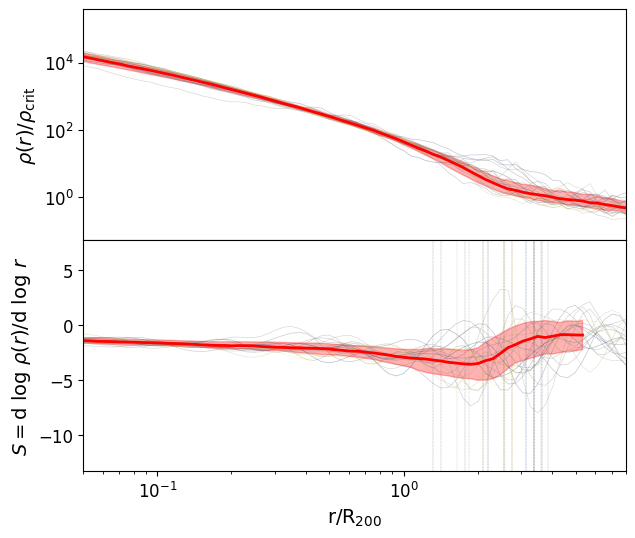

In [10]:
fig = plt.figure(figsize=(7, 6))
fig.subplots_adjust(hspace=0.0)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
colors = plt.cm.cividis(np.linspace(0, 1, max(R)+1))
for i in R:
# for i in range(10):
    ax1.plot(log_bins, DM_density[i]/rhonorm, color=colors[i],linewidth=0.5, alpha=0.3)
    smoothed_density = savgol_filter(DM_density[i], window_length=15, polyorder=4, deriv=0, delta=0.1)
    log_D = np.log(smoothed_density)
    log_r = np.log(log_bins)
    d_log_D = np.gradient(log_D, log_r)   
    # ax2.plot(log_bins, d_log_D, color='blue', linestyle='-', linewidth=2.0)
    smoothed_d_log_D = savgol_filter(d_log_D, window_length=15, polyorder=4, deriv=0, delta=0.01)
    ax2.plot(log_bins, smoothed_d_log_D, color=colors[i], linestyle='-', linewidth=0.5, alpha=0.3) # colors[i % len(colors)]
    
    restricted_indices = np.where((log_bins >= 0.5) & (log_bins <= 4))[0]
    rr = log_bins[restricted_indices]
    smoothed_d_log_D_restricted = smoothed_d_log_D[restricted_indices]
    
    r_splash_index = np.argmin(smoothed_d_log_D_restricted)
    r_splash = rr[r_splash_index]

    interp_func = interp1d(log_bins, smoothed_d_log_D, kind='cubic')
    log_bins_dense = np.linspace(r_splash-0.1, r_splash+0.1, 1000)
    smoothed_d_log_D_dense = interp_func(log_bins_dense)
    max_index = np.argmax(smoothed_d_log_D_dense)
    r_splash = log_bins_dense[max_index]

    # Rsp.append(r_splash)
    ax2.axvline(x=r_splash, color=colors[i], linestyle='--', linewidth=0.2)

median_DM_density = np.median(DM_density, axis=0)
percentile16_DM_density = np.percentile(DM_density, 16, axis=0)
percentile84_DM_density = np.percentile(DM_density, 84, axis=0)

ax1.plot(log_bins, median_DM_density / rhonorm, color='red', linewidth=2.0, alpha=1)
ax1.fill_between(log_bins, percentile16_DM_density / rhonorm, percentile84_DM_density / rhonorm, color='red', alpha=0.3)

d_log_D_all = []
for density in DM_density:
    smoothed_density = savgol_filter(density, window_length=15, polyorder=4, deriv=0, delta=0.1)
    log_D = np.log(smoothed_density)
    d_log_D = np.gradient(log_D, log_r)
    smoothed_d_log_D = savgol_filter(d_log_D, window_length=15, polyorder=4, deriv=0, delta=0.01)
    d_log_D_all.append(smoothed_d_log_D)

d_log_D_all = np.array(d_log_D_all)
median_d_log_D = np.median(d_log_D_all, axis=0)
percentile16_d_log_D = np.percentile(d_log_D_all, 16, axis=0)
percentile84_d_log_D = np.percentile(d_log_D_all, 84, axis=0)

ax2.plot(log_bins, median_d_log_D, color='red', linestyle='-', linewidth=2.0)
ax2.fill_between(log_bins, percentile16_d_log_D, percentile84_d_log_D, color='red', alpha=0.3)

ax1.set_ylabel(r'$\rho(r)/\rho_{\rm crit}$', fontsize=14) #{\rm Log}_{10} 
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(0.05,8)
ax1.get_xaxis().set_visible(False)
ax1.tick_params(axis='both', which='major', labelsize=12)

ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xscale('log')
# ax2.set_yscale('log')
ax2.set_xlabel(r'${\rm r/R}_{200}$', fontsize=14)
ax2.set_ylabel(r'$S = {\rm d~log}~\rho(r) / {\rm d~log}~r$', fontsize=14)
# ax2.set_ylabel(r'$S$')
ax2.set_xlim(0.05,8)
# ax2.set_ylim(-6.8,3)

(0.05, 8)

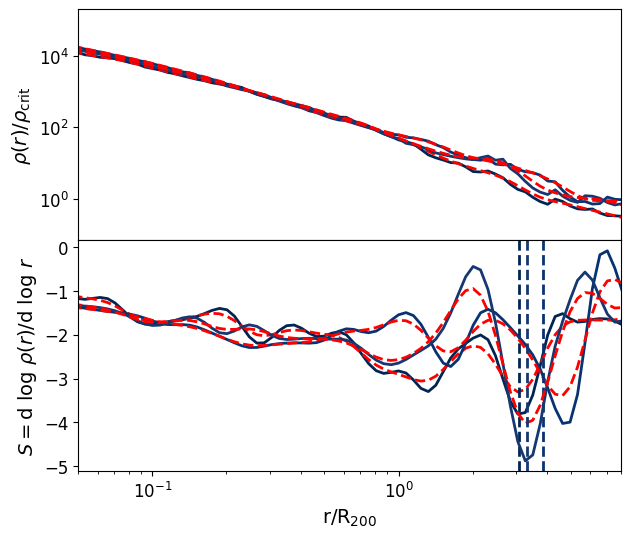

In [15]:
fig = plt.figure(figsize=(7, 6))
fig.subplots_adjust(hspace=0.0)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
colors = plt.cm.cividis(np.linspace(0, 1, 664))
for i in R[1:4]:
# for i in range(10):
    ax1.plot(log_bins, DM_density[i]/rhonorm, color=colors[i],linewidth=2)
    # smoothed_density = savgol_filter(DM_density[i], window_length=15, polyorder=4, deriv=0, delta=0.1)
    smoothed_density = gaussian_filter1d(DM_density[i], sigma=2)
    ax1.plot(log_bins, smoothed_density/rhonorm, color='r',linestyle='--',linewidth=2)
    log_D = np.log(smoothed_density)
    log_r = np.log(log_bins)
    d_log_D = np.gradient(log_D, log_r)   
    ax2.plot(log_bins, d_log_D, color=colors[i], linestyle='-', linewidth=2.0)
    # smoothed_d_log_D = savgol_filter(d_log_D, window_length=15, polyorder=4, deriv=0, delta=0.01)
    smoothed_d_log_D = gaussian_filter1d(d_log_D, sigma=2)
    ax2.plot(log_bins, smoothed_d_log_D, color='r', linestyle='--', linewidth=2) # colors[i % len(colors)]
    
    restricted_indices = np.where((log_bins >= 0.5) & (log_bins <= 4))[0]
    rr = log_bins[restricted_indices]
    smoothed_d_log_D_restricted = smoothed_d_log_D[restricted_indices]
    
    r_splash_index = np.argmin(smoothed_d_log_D_restricted)
    r_splash = rr[r_splash_index]

    interp_func = interp1d(log_bins, smoothed_d_log_D, kind='cubic')
    log_bins_dense = np.linspace(r_splash-0.1, r_splash+0.1, 1000)
    smoothed_d_log_D_dense = interp_func(log_bins_dense)
    max_index = np.argmin(smoothed_d_log_D_dense)
    r_splash = log_bins_dense[max_index]

    # Rsp.append(r_splash)
    ax2.axvline(x=r_splash, color=colors[i], linestyle='--', linewidth=2)

ax1.set_ylabel(r'$\rho(r)/\rho_{\rm crit}$', fontsize=14) #{\rm Log}_{10} 
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(0.05,8)
ax1.get_xaxis().set_visible(False)
ax1.tick_params(axis='both', which='major', labelsize=12)

ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xscale('log')
# ax2.set_yscale('log')
ax2.set_xlabel(r'${\rm r/R}_{200}$', fontsize=14)
ax2.set_ylabel(r'$S = {\rm d~log}~\rho(r) / {\rm d~log}~r$', fontsize=14)
# ax2.set_ylabel(r'$S$')
ax2.set_xlim(0.05,8)
# ax2.set_ylim(-6.8,3)